# Question 1 — TWFE & Event-Study

## a) TWFE

Load the dataset available. Note that asmrs is the outcome variable, pcinc, asmrh and cases are controls. The dataset already includes treatment and post-treatment variables.

In [1]:
import pandas as pd

url = "https://raw.githubusercontent.com/LOST-STATS/LOST-STATS.github.io/master/Model_Estimation/Data/Event_Study_DiD/bacon_example.csv"

df = pd.read_csv(url)

print(df.head())
print(df.shape)

   stfips  year    _nfd  post      asmrs         pcinc     asmrh     cases  \
0       1  1964  1971.0     0  35.639885  12406.178537  5.007341  0.012312   
1       1  1965  1971.0     0  41.543755  13070.206738  4.425367  0.010419   
2       1  1966  1971.0     0  34.252335  13526.663217  4.874819  0.009900   
3       1  1967  1971.0     0  34.465023  13918.189823  5.362014  0.009975   
4       1  1968  1971.0     0  40.440105  14684.808682  4.643759  0.012401   

      weight         copop  
0  1715156.0  1.715156e+06  
1  1715156.0  1.725186e+06  
2  1715156.0  1.735219e+06  
3  1715156.0  1.745250e+06  
4  1715156.0  1.755283e+06  
(1617, 10)


Estimate a Two-Way Fixed Effects (TWFE) regression with unit and time fixed effects.

In [2]:
# Two-Way Fixed Effects DID:
# outcome: asmrs
# controls: pcinc, asmrh, cases
# treatment: post
# unit FE: stfips
# time FE: year

import statsmodels.formula.api as smf

twfe_model = smf.ols(
    "asmrs ~ post + pcinc + asmrh + cases + C(stfips) + C(year)",
    data=df
).fit(
    cov_type="cluster", # errores estándar robustos clusterizados.
    cov_kwds={"groups": df["stfips"]} # cluster a nivel de estado
)

print(twfe_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  asmrs   R-squared:                       0.710
Model:                            OLS   Adj. R-squared:                  0.694
Method:                 Least Squares   F-statistic:                     32.13
Date:                Sat, 29 Nov 2025   Prob (F-statistic):           2.00e-23
Time:                        10:11:33   Log-Likelihood:                -6107.4
No. Observations:                1617   AIC:                         1.238e+04
Df Residuals:                    1532   BIC:                         1.284e+04
Df Model:                          84                                         
Covariance Type:              cluster                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          51.8784      3.392     

/Users/rominarattoyanez/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 84, but rank is 36
  warnings.warn('covariance of constraints does not have full '


## b) Cleaning for Event-Study

1. Create the relative time variable (event time = time − treatment time).

In [3]:
# Obtener año de tratamiento por estado (stfips)

# Primer año en que post == 1
treat_time_by_state = (
    df[df["post"] == 1]        # Filtra el dataset para quedarte solo con filas donde post == 1 (periodos post–tratamiento).
    .groupby("stfips")["year"] # Agrupa por estado 
    .min()                     # Extrae el año mínimo donde post==1.
)

# Crear columna de año de tratamiento en el dataframe
df["treat_time"] = df["stfips"].map(treat_time_by_state)

# Crear event_time = year - treat_time
df["event_time"] = df["year"] - df["treat_time"] # Para estados nunca tratados (treat_time NaN), event_time queda NaN

# Verificar
print(df[["stfips", "year", "post", "treat_time", "event_time"]].head(15))

    stfips  year  post  treat_time  event_time
0        1  1964     0      1971.0        -7.0
1        1  1965     0      1971.0        -6.0
2        1  1966     0      1971.0        -5.0
3        1  1967     0      1971.0        -4.0
4        1  1968     0      1971.0        -3.0
5        1  1969     0      1971.0        -2.0
6        1  1970     0      1971.0        -1.0
7        1  1971     1      1971.0         0.0
8        1  1972     1      1971.0         1.0
9        1  1973     1      1971.0         2.0
10       1  1974     1      1971.0         3.0
11       1  1975     1      1971.0         4.0
12       1  1976     1      1971.0         5.0
13       1  1977     1      1971.0         6.0
14       1  1978     1      1971.0         7.0


2. Provide a frequency table or descriptive summary of event time.

In [4]:
# Tabla de frecuencias (incluye NaN)
freq_full = df["event_time"].value_counts(dropna=False).sort_index()
print("Frecuencia de event_time (incluyendo NaN):")
print(freq_full)

Frecuencia de event_time (incluyendo NaN):
event_time
-21.0      1
-20.0      2
-19.0      2
-18.0      2
-17.0      2
-16.0      3
-15.0      3
-14.0      3
-13.0      6
-12.0      7
-11.0      9
-10.0     12
-9.0      22
-8.0      25
-7.0      32
-6.0      34
-5.0      36
-4.0      36
-3.0      36
-2.0      36
-1.0      36
 0.0      44
 1.0      44
 2.0      44
 3.0      44
 4.0      44
 5.0      44
 6.0      44
 7.0      44
 8.0      44
 9.0      44
 10.0     44
 11.0     44
 12.0     43
 13.0     42
 14.0     42
 15.0     42
 16.0     42
 17.0     41
 18.0     41
 19.0     41
 20.0     38
 21.0     37
 22.0     35
 23.0     32
 24.0     22
 25.0     19
 26.0     12
 27.0     10
 28.0      8
 29.0      8
 30.0      8
 31.0      8
 32.0      8
 NaN     165
Name: count, dtype: int64


In [5]:
# Resumen descriptivo
event_nonmissing = df["event_time"].dropna()
print("\nResumen descriptivo de event_time (solo tratados):")
print(event_nonmissing.describe())


Resumen descriptivo de event_time (solo tratados):
count    1452.000000
mean        8.159091
std        10.707574
min       -21.000000
25%         0.000000
50%         8.000000
75%        17.000000
max        32.000000
Name: event_time, dtype: float64


3. Based on the distribution, choose reasonable upper and lower bounds for grouping extreme event times.

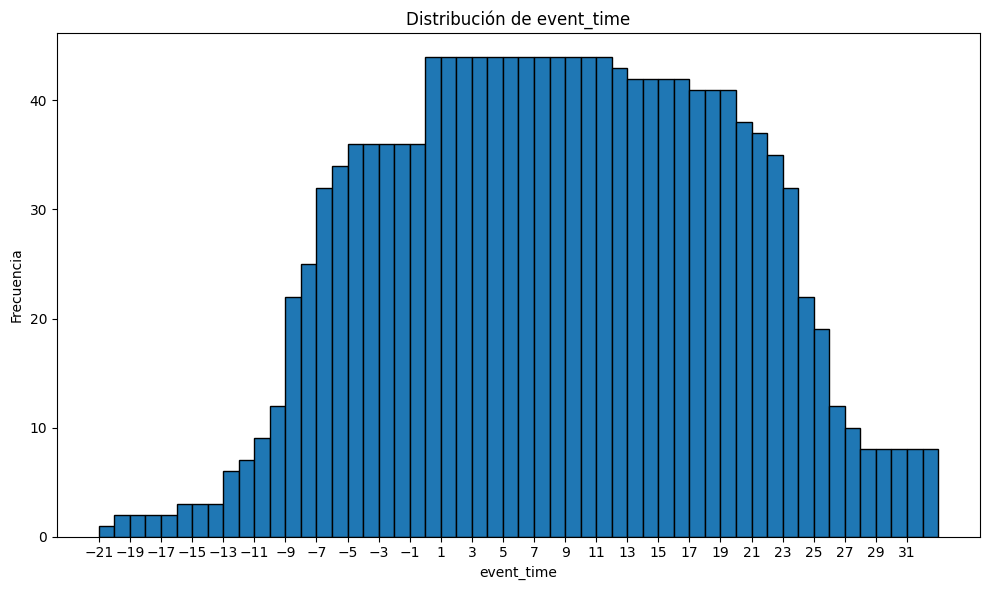

In [6]:
import matplotlib.pyplot as plt
import numpy as np

valid = df["event_time"].dropna() # Filtrar solo event_time válido

plt.figure(figsize=(10,6))
plt.hist(valid, bins=range(int(valid.min()), int(valid.max())+2), edgecolor="black")
plt.title("Distribución de event_time")
plt.xlabel("event_time")
plt.ylabel("Frecuencia")
plt.xticks(range(int(valid.min()), int(valid.max())+1, 2))  # ticks cada 2
plt.tight_layout()
plt.show()

In [7]:
lower, upper = -10, 20

df["event_time_group"] = df["event_time"] # Crear una nueva variable agrupada

df.loc[df["event_time"] <= lower, "event_time_group"] = lower
df.loc[df["event_time"] >= upper, "event_time_group"] = upper

4. Question: Why do we usually group very distant event times together?

We group very distant event times because there are too few observations in those periods, which makes the coefficients noisy, unstable, hard to interpret, and irrelevant for policy. Binning the extremes improves precision, readability, and the reliability of the event-study.

5. Create relative-time dummy variables.

In [8]:
# Crear las dummies de event_time_group
df["event_time_group_int"] = df["event_time_group"].astype("Int64") # Convertir a entero "nullable" (permite NaN)
event_dummies = pd.get_dummies(df["event_time_group_int"], prefix="event") # Crear dummies de tiempo relativo
print(event_dummies.columns)

# Elegir y quitar el período base
base_period = -1
event_dummies = event_dummies.drop(columns=[f"event_{base_period}"]) # Eliminar la dummy del período base para evitar multicolinealidad

# Unir las dummies al dataframe
df = pd.concat([df, event_dummies], axis=1)

Index(['event_-10', 'event_-9', 'event_-8', 'event_-7', 'event_-6', 'event_-5',
       'event_-4', 'event_-3', 'event_-2', 'event_-1', 'event_0', 'event_1',
       'event_2', 'event_3', 'event_4', 'event_5', 'event_6', 'event_7',
       'event_8', 'event_9', 'event_10', 'event_11', 'event_12', 'event_13',
       'event_14', 'event_15', 'event_16', 'event_17', 'event_18', 'event_19',
       'event_20'],
      dtype='object')


## c) Event-Study Estimation

1. Estimate an Event-Study model using the relative-time dummies.

In [9]:
import statsmodels.formula.api as smf

# Nos quedamos solo con observaciones con event_time_group definido
df_es = df.dropna(subset=["event_time_group"]).copy()

# Seleccionar sólo las dummies de tiempo relativo
dummy_cols = [
    c for c in df_es.columns  # Recorre todas las columnas de df_es
    if c.startswith("event_") # Selecciona las que empiezan con "event_"
    and c not in ["event_time", "event_time_group", "event_time_group_int"]
]

print("Dummies usadas:", dummy_cols)

# 3) Construir la parte de las dummies usando Q("nombre")
dummies_rhs = " + ".join([f'Q("{c}")' for c in dummy_cols])

formula = (
    "asmrs ~ "
    + dummies_rhs
    + " + pcinc + asmrh + cases"
    + " + C(stfips) + C(year)"
)

print("Fórmula usada:\n", formula)

es_model = smf.ols(
    formula,
    data=df_es
).fit(
    cov_type="cluster",
    cov_kwds={"groups": df_es["stfips"]}
)

print(es_model.summary())

Dummies usadas: ['event_-10', 'event_-9', 'event_-8', 'event_-7', 'event_-6', 'event_-5', 'event_-4', 'event_-3', 'event_-2', 'event_0', 'event_1', 'event_2', 'event_3', 'event_4', 'event_5', 'event_6', 'event_7', 'event_8', 'event_9', 'event_10', 'event_11', 'event_12', 'event_13', 'event_14', 'event_15', 'event_16', 'event_17', 'event_18', 'event_19', 'event_20']
Fórmula usada:
 asmrs ~ Q("event_-10") + Q("event_-9") + Q("event_-8") + Q("event_-7") + Q("event_-6") + Q("event_-5") + Q("event_-4") + Q("event_-3") + Q("event_-2") + Q("event_0") + Q("event_1") + Q("event_2") + Q("event_3") + Q("event_4") + Q("event_5") + Q("event_6") + Q("event_7") + Q("event_8") + Q("event_9") + Q("event_10") + Q("event_11") + Q("event_12") + Q("event_13") + Q("event_14") + Q("event_15") + Q("event_16") + Q("event_17") + Q("event_18") + Q("event_19") + Q("event_20") + pcinc + asmrh + cases + C(stfips) + C(year)
                            OLS Regression Results                            
Dep. Variable:

/Users/rominarattoyanez/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 108, but rank is 43
  warnings.warn('covariance of constraints does not have full '


2. Store coefficient estimates and standard errors.

In [10]:
import pandas as pd
import numpy as np

rows = []

for name, beta in es_model.params.items():

    # Asegurar que estamos capturando solo dummies de evento
    if name.startswith('Q("event_'):

        # 1. Limpiar el nombre: quitar Q("  y  ")
        clean = name.replace('Q("', '').replace('")', '')

        # 2. Quitar cualquier sufijo como [T.True] o [T.1] o [T.whatever]
        clean = clean.split("[")[0]       # -> event_-10

        # 3. Extraer el número
        level = clean.replace("event_", "")   # -> -10
        event_time = int(level)

        # 4. Error estándar asociado
        se = es_model.bse[name]

        rows.append({"event_time": event_time, "beta": beta, "se": se})

# Crear DataFrame
es_df = pd.DataFrame(rows)

# Añadir período base t=-1
es_df = pd.concat(
    [es_df, pd.DataFrame([{"event_time": -1, "beta": 0.0, "se": 0.0}])],
    ignore_index=True
)

# Ordenar
es_df = es_df.sort_values("event_time").reset_index(drop=True)

# Intervalos de confianza
z = 1.96
es_df["ci_low"] = es_df["beta"] - z * es_df["se"]
es_df["ci_high"] = es_df["beta"] + z * es_df["se"]

print(es_df)

    event_time       beta        se     ci_low    ci_high
0          -10   1.863740  4.727259  -7.401688  11.129168
1           -9  -0.757087  4.540412  -9.656294   8.142121
2           -8   0.955000  4.495390  -7.855963   9.765964
3           -7   2.526004  4.899054  -7.076141  12.128149
4           -6   2.223614  3.219030  -4.085685   8.532912
5           -5  -0.110914  2.920061  -5.834233   5.612405
6           -4   2.156710  2.557815  -2.856607   7.170027
7           -3  -1.218916  3.060959  -7.218395   4.780563
8           -2   0.113140  2.586893  -4.957171   5.183451
9           -1   0.000000  0.000000   0.000000   0.000000
10           0  -1.627445  2.814574  -7.144010   3.889120
11           1  -2.669908  2.898486  -8.350940   3.011124
12           2  -3.625309  3.635588 -10.751061   3.500443
13           3  -2.954777  3.028278  -8.890202   2.980647
14           4  -4.722031  3.032906 -10.666526   1.222465
15           5  -4.071059  3.013494  -9.977507   1.835390
16           6

3. Plot the event-study coefficients with confidence intervals.

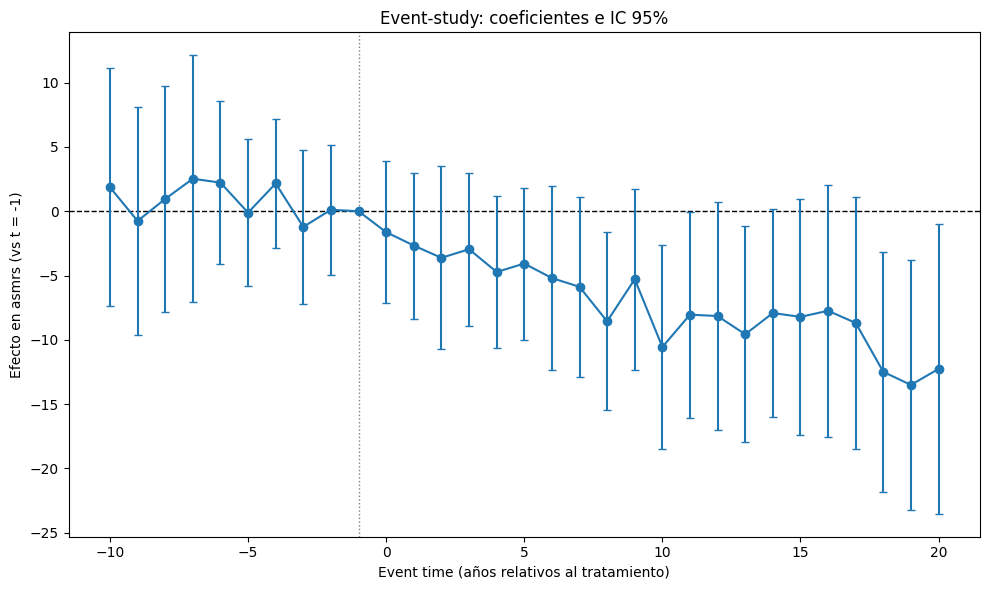

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Línea horizontal en 0 (sin efecto)
plt.axhline(0, color="black", linewidth=1, linestyle="--")

# Línea vertical en el período base (t = -1)
plt.axvline(-1, color="grey", linewidth=1, linestyle=":")

# Gráfico con barras de error (IC 95%)
plt.errorbar(
    es_df["event_time"],
    es_df["beta"],
    yerr=z * es_df["se"],
    fmt="o-",
    capsize=3
)

plt.xlabel("Event time (años relativos al tratamiento)")
plt.ylabel("Efecto en asmrs (vs t = -1)")
plt.title("Event-study: coeficientes e IC 95%")
plt.tight_layout()
plt.show()

# Question 2 — CSDiD

## a) Estimation
Using CSDiD, estimate ATT(g,t). Present results in a clean table. (You may choose which controls to include.)

In [13]:
import pandas as pd
import numpy as np

# Definir G = cohorte de tratamiento (G = 0 para nunca tratados, año de primera adopción si es tratado)
df["G"] = df["treat_time"].fillna(0).astype(int)
print("Valores únicos de G (cohortes):", sorted(df["G"].unique()))

# ATT(g,t) "tipo CSDiD"
# Controles: nunca tratados + not-yet-treated en el año t
# Tiempo base: s = g - 1 (último año pre-tratamiento)

rows = []

cohortes_tratadas = sorted(g for g in df["G"].unique() if g != 0) # Cohortes tratadas (excluimos G=0)

for g in cohortes_tratadas:
    s = g - 1  # año base (último pre)
    
    treated_base = df[(df["G"] == g) & (df["year"] == s)] # treated_base = obs de la cohorte g en el último año antes del tratamiento.
    if treated_base.empty: # Si no hay datos en el año g-1 para la cohorte g, no podemos hacer DID 2x2.
        continue

    years_g = sorted(df.loc[df["G"] == g, "year"].unique()) # Para cada cohorte, consideramos todos los años en que aparece
    for t in years_g:
        if t <= s:
            continue  # Solo años estrictamente posteriores al año base

        # ---- Tratados ----
        treated_t = df[(df["G"] == g) & (df["year"] == t)] # treated_t = unidades tratadas en el año t
        if treated_t.empty:
            continue

        # ---- Controles: nunca tratados (treat_time isna)+ not-yet-treated (treat_time > t) en t ----
        control_t = df[ # control_t = controles en el año t
            (df["year"] == t) &
            (df["treat_time"].isna() | (df["treat_time"] > t))]

        control_base = df[ # control_base = controles en el año base s = g − 1
            (df["year"] == s) &
            (df["treat_time"].isna() | (df["treat_time"] > g))] # Nota: usamos como control los nunca tratados y los que serán tratados después de g (todavía no tratados en s).

        if control_t.empty or control_base.empty: # Sin controles en alguno de los años, no se puede calcular ATT(g,t)
            continue

        # Promedios de outcomes
        mu_g_s = treated_base["asmrs"].mean()
        mu_g_t = treated_t["asmrs"].mean()

        mu_c_s = control_base["asmrs"].mean()
        mu_c_t = control_t["asmrs"].mean()

        # DID 2x2 estilo C&S: ATT(g,t) = (Y_g,t - Y_g,s) - (Y_c,t - Y_c,s)
        att_gt = (mu_g_t - mu_g_s) - (mu_c_t - mu_c_s)

        rows.append({
            "g": g,
            "t": t,
            "ATT_gt": att_gt,
            "n_treated_s": len(treated_base),
            "n_treated_t": len(treated_t),
            "n_control_s": len(control_base),
            "n_control_t": len(control_t)
        })

# Tabla final ATT(g,t) limpia
att_gt_table = (
    pd.DataFrame(rows)
    .sort_values(["g", "t"])
    .assign(ATT_gt=lambda d: d["ATT_gt"].round(3))
    .reset_index(drop=True)
)

print(att_gt_table.head(20))

Valores únicos de G (cohortes): [0, 1964, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1980, 1984, 1985]
       g     t  ATT_gt  n_treated_s  n_treated_t  n_control_s  n_control_t
0   1969  1969   1.214            2            2           39           39
1   1969  1970  -7.163            2            2           39           37
2   1969  1971  -8.858            2            2           39           30
3   1969  1972   0.002            2            2           39           27
4   1969  1973  14.173            2            2           39           17
5   1969  1974  10.647            2            2           39           14
6   1969  1975  13.418            2            2           39           12
7   1969  1976   1.476            2            2           39           11
8   1969  1977  11.983            2            2           39            8
9   1969  1978   5.533            2            2           39            8
10  1969  1979   8.205            2            2           39

## b) Aggregations



Compute and present:

1. Aggregation by group
2. Aggregation by period
3. Aggregation by event-time

In [14]:
att_by_group = (
    att_gt_table
    .groupby("g")
    .agg(
        ATT_g=("ATT_gt", "mean"),
        n_gt=("ATT_gt", "size")   # cuántos (g,t) entran en el promedio
    )
    .reset_index()
)

att_by_group["ATT_g"] = att_by_group["ATT_g"].round(3)

print("Aggregation by group (cohort):")
print(att_by_group)

Aggregation by group (cohort):
       g   ATT_g  n_gt
0   1969   7.852    28
1   1970 -18.596    27
2   1971   1.554    26
3   1972   5.405    25
4   1973   2.624    24
5   1974  -3.859    23
6   1975   2.824    22
7   1976  -6.832    21
8   1977 -12.436    20
9   1980  -7.894    17
10  1984  -7.921    13
11  1985  11.956    12


In [15]:
att_by_period = (
    att_gt_table
    .groupby("t")
    .agg(
        ATT_t=("ATT_gt", "mean"),
        n_gt=("ATT_gt", "size")
    )
    .reset_index()
)

att_by_period["ATT_t"] = att_by_period["ATT_t"].round(3)

print("Aggregation by period (calendar time):")
print(att_by_period)

Aggregation by period (calendar time):
       t   ATT_t  n_gt
0   1969   1.214     1
1   1970  -3.327     2
2   1971  -5.806     3
3   1972  -4.486     4
4   1973   5.054     5
5   1974   4.987     6
6   1975   5.426     7
7   1976   1.586     8
8   1977  10.586     9
9   1978  -2.119     9
10  1979   1.585     9
11  1980  -5.256    10
12  1981   2.014    10
13  1982  -1.561    10
14  1983   2.724    10
15  1984  -0.342    11
16  1985   1.720    12
17  1986  -3.617    12
18  1987  -3.832    12
19  1988  -8.622    12
20  1989  -2.408    12
21  1990  -1.605    12
22  1991  -8.213    12
23  1992  -9.960    12
24  1993  -3.460    12
25  1994  -5.765    12
26  1995  -6.606    12
27  1996  -4.903    12


In [16]:
# Crear columna de event-time
att_gt_table["event_time"] = att_gt_table["t"] - att_gt_table["g"]

att_by_event_time = (
    att_gt_table
    .groupby("event_time")
    .agg(
        ATT_event=("ATT_gt", "mean"),
        n_gt=("ATT_gt", "size")
    )
    .reset_index()
    .sort_values("event_time")
)

att_by_event_time["ATT_event"] = att_by_event_time["ATT_event"].round(3)

print("Aggregation by event-time (t - g):")
print(att_by_event_time)

Aggregation by event-time (t - g):
    event_time  ATT_event  n_gt
0            0      0.314    12
1            1      2.302    12
2            2      1.048    12
3            3     -0.155    12
4            4      1.863    12
5            5      2.920    12
6            6      1.005    12
7            7     -0.327    12
8            8     -2.024    12
9            9      1.163    12
10          10     -4.381    12
11          11     -1.777    12
12          12     -3.190    11
13          13     -3.669    10
14          14     -2.901    10
15          15     -5.206    10
16          16     -4.902    10
17          17     -6.223     9
18          18     -6.706     9
19          19     -8.386     9
20          20     -4.395     8
21          21     -5.929     7
22          22     -6.871     6
23          23     -4.586     5
24          24     -3.838     4
25          25     -6.821     3
26          26    -12.347     2
27          27     15.333     1


## c) Explanation of Aggregations

Explain:

- Meaning of aggregation by group
- Meaning of aggregation by period
- Meaning of aggregation by event-time
- Question: Which aggregation is most comparable to the TWFE Event-Study coefficients?

#### **1. Aggregation by Group (ATT(g))**
Averages (ATT(g,t)) over all post-treatment periods for each cohort (g).
**Meaning:** Measures how large the treatment effect was *on average for each cohort* across time.

#### **2. Aggregation by Period (ATT(t))**
Averages (ATT(g,t)) across all cohorts already treated in calendar year (t).
**Meaning:** Measures the *average effect in a given year*, pooling all treated cohorts.

#### **3. Aggregation by Event-Time (ATT(k))**
Averages (ATT(g, g+k)) across cohorts by time relative to treatment ((k = t - g)).
**Meaning:** Shows *dynamic effects*: how the treatment impact evolves (k) years before/after treatment.

#### **Which aggregation matches TWFE Event-Study coefficients?**
Event-time aggregation: TWFE event-study coefficients also estimate effects by time relative to treatment ((k)).

## d) Compare CSDiD and Event-Study Results
- Create a table comparing:(i) Event-time aggregated ATT from CSDiD & (ii) Event-study coefficients from the TWFE model
- Produce a combined coefficient plot.
- Provide a brief comparison.

In [18]:
# ============================
# 1. TWFE event-study 
# es_df contiene: event_time, beta, se, ci_low, ci_high
# ============================
twfe_event = es_df[["event_time", "beta", "se"]].rename(
    columns={
        "beta": "beta_TWFE",
        "se": "se_TWFE"
    }
)

# ============================
# 2. CSDiD event-time aggregation
# att_by_event_time contiene: event_time, ATT_event, n_gt
# ============================
csdid_event = att_by_event_time.rename(
    columns={
        "ATT_event": "ATT_CSDiD",
        "n_gt": "n_cells_CSDiD"
    }
)

# ============================
# 3. MERGE: tabla conjunta TWFE + CSDiD por event_time
# ============================
comparison = (
    twfe_event
    .merge(csdid_event, on="event_time", how="inner")
    .sort_values("event_time")
    .reset_index(drop=True)
)

comparison["beta_TWFE"] = comparison["beta_TWFE"].round(3)
comparison["se_TWFE"]   = comparison["se_TWFE"].round(3)
comparison["ATT_CSDiD"] = comparison["ATT_CSDiD"].round(3)

print("\n==============================")
print("Comparación TWFE vs CSDiD")
print("==============================")
print(comparison)


Comparación TWFE vs CSDiD
    event_time  beta_TWFE  se_TWFE  ATT_CSDiD  n_cells_CSDiD
0            0     -1.627    2.815      0.314             12
1            1     -2.670    2.898      2.302             12
2            2     -3.625    3.636      1.048             12
3            3     -2.955    3.028     -0.155             12
4            4     -4.722    3.033      1.863             12
5            5     -4.071    3.013      2.920             12
6            6     -5.196    3.645      1.005             12
7            7     -5.879    3.577     -0.327             12
8            8     -8.563    3.528     -2.024             12
9            9     -5.287    3.593      1.163             12
10          10    -10.558    4.055     -4.381             12
11          11     -8.042    4.091     -1.777             12
12          12     -8.151    4.526     -3.190             11
13          13     -9.571    4.289     -3.669             10
14          14     -7.917    4.134     -2.901             

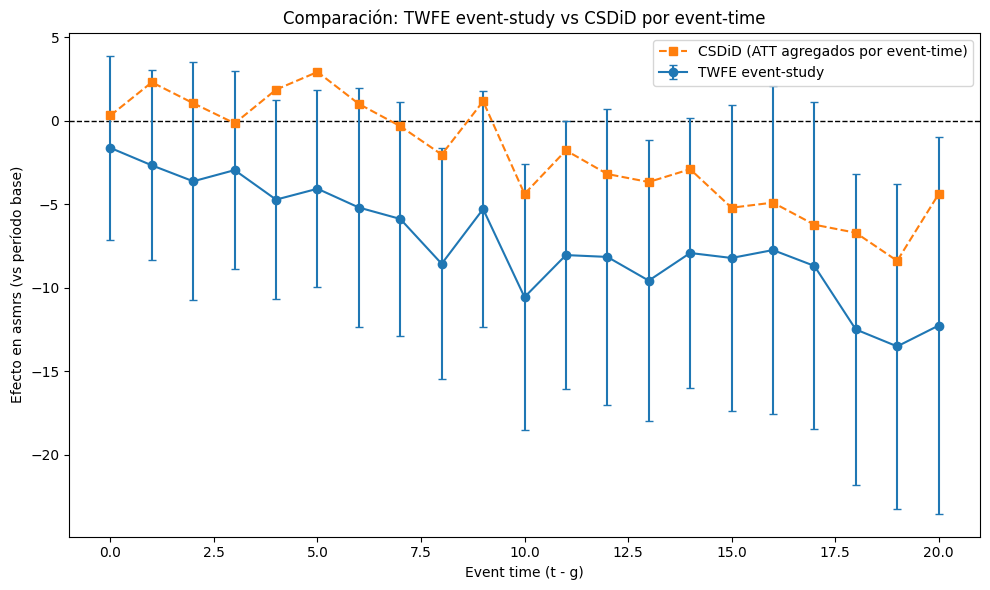

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Parámetro para IC 95% del TWFE
z = 1.96

plt.figure(figsize=(10, 6))

# Línea horizontal en 0 (sin efecto)
plt.axhline(0, color="black", linewidth=1, linestyle="--")

# --- 1) TWFE Event-Study: puntos + barras de error ---
plt.errorbar(
    comparison["event_time"],
    comparison["beta_TWFE"],
    yerr=z * comparison["se_TWFE"],
    fmt="o-",
    capsize=3,
    label="TWFE event-study"
)

# --- 2) CSDiD agregado por event-time: línea + marcadores ---
plt.plot(
    comparison["event_time"],
    comparison["ATT_CSDiD"],
    marker="s",
    linestyle="--",
    label="CSDiD (ATT agregados por event-time)"
)

# Labels y formato
plt.xlabel("Event time (t - g)")
plt.ylabel("Efecto en asmrs (vs período base)")
plt.title("Comparación: TWFE event-study vs CSDiD por event-time")
plt.legend()
plt.tight_layout()
plt.show()

Brief Comparison: TWFE exaggerates negative effects due to bad comparisons; CSDiD provides cleaner, more credible dynamic effects by using valid control groups at each g,t.